In [2]:
import numpy as np # linear algebra
import pandas as pd
import os
import csv

import torch
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import models
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from functools import partial
from torch.utils.data import Subset
import numpy as np
from sklearn.metrics import confusion_matrix

/home/yulin/anaconda3/envs/final/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/yulin/anaconda3/envs/final/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIlEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


## 

In [3]:
class SpectroDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.labels_df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = self.labels_df.iloc[idx, 0]
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path)
        # print(np.array(image).shape)

        if self.transform:
            image = self.transform(image)

        label = self.labels_df.iloc[idx, 1]
        label = torch.tensor(label, dtype=torch.long)

        return image, label

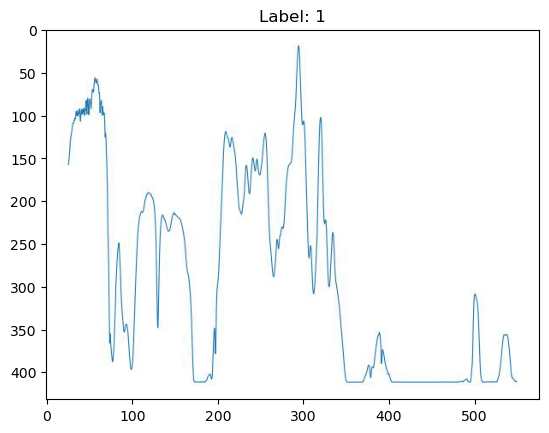

In [4]:
# transform training data
train_transform = transforms.Compose([
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomCrop(96, padding=4),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# transform validation data
val_transform = transforms.ToTensor()

dataset = SpectroDataset('/home/yulin/PycharmProjects/final/train_data2.csv', '/home/yulin/PycharmProjects/final/train2',train_transform)
train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
test_dataset = SpectroDataset('/home/yulin/PycharmProjects/final/test_data2.csv', '/home/yulin/PycharmProjects/final/test2',train_transform)

idx = torch.randint(len(dataset), size=(1,)).item()
img, label = dataset[idx]

# show a sample
img = img.numpy().transpose((1, 2, 0))
plt.imshow(img)
plt.title('Label: {}'.format(label))
plt.show()

In [5]:
def train():
    net = models.resnet18(pretrained=True)
    net = net.train()

    num_features = net.fc.in_features
    net.fc = nn.Linear(num_features, 7)

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.0005, momentum=0.9)

    trainloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=16,
        shuffle=True)
    valloader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=16,
        shuffle=True)

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=16,
        shuffle=False)

    # Lists to store loss and accuracy values for plotting
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(30):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            epoch_steps += 1
            total += labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

        train_loss = (running_loss / epoch_steps)
        train_acc = correct / total

        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        print("epoch %d " % (epoch + 1))
        print('train loss: %.4f, train accuracy: %.4f' % (
            train_loss, train_acc))

        # Validation loss
        net.eval()
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        y_true = []
        y_pred = []
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # calculate confusion matrix
                y_true += labels.cpu().numpy().tolist()
                y_pred += predicted.cpu().numpy().tolist()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        loss = (val_loss / val_steps)
        accuracy = correct / total

        val_loss_history.append(loss)
        val_acc_history.append(accuracy)

        print('Validation loss: %.4f, Validation accuracy: %.4f' % (
            loss, accuracy))

        cm = confusion_matrix(y_true, y_pred)
        print('Confusion matrix:\n', cm)

    net.eval()
    test_predictions = []
    for i, data in enumerate(test_loader, 0):
        with torch.no_grad():
            inputs = data[0].to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            test_predictions += predicted.cpu().numpy().tolist()

    test_df = pd.read_csv('/home/yulin/PycharmProjects/final/test_data2.csv')
    test_df['Label'] = test_predictions
    test_df.to_csv('submission.csv', index=False)
    print("Your submission was successfully saved!")

    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.plot(train_acc_history, label='Train Accuracy')
    plt.plot(val_acc_history, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    return net

In [6]:
def process_csv_file(file_path):
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        next(reader)  # 跳过标题行

        for row in reader:
            label = int(row[1])
            name = row[0].split(".dpt.jpg")[0]  # 删除后缀

            if label == 2 or label == 4:
                print(f"{name}：recyclable")
            else:
                print(f"{name}：non-recyclable")

In [ ]:
net = train()

/home/yulin/anaconda3/envs/final/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/yulin/anaconda3/envs/final/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch 1 
train loss: 2.1248, train accuracy: 0.2143
Validation loss: 2.1039, Validation accuracy: 0.1429
Confusion matrix:
 [[0 0 0 3]
 [0 0 0 1]
 [0 0 0 2]
 [0 0 0 1]]
epoch 2 
train loss: 1.9677, train accuracy: 0.2143
Validation loss: 1.8004, Validation accuracy: 0.1429
Confusion matrix:
 [[0 0 0 3]
 [0 0 0 1]
 [0 0 0 2]
 [0 0 0 1]]
epoch 3 
train loss: 1.7990, train accuracy: 0.2143
Validation loss: 1.5748, Validation accuracy: 0.4286
Confusion matrix:
 [[2 0 0 1]
 [1 0 0 0]
 [2 0 0 0]
 [0 0 0 1]]
epoch 4 
train loss: 1.6792, train accuracy: 0.3571
Validation loss: 1.4618, Validation accuracy: 0.5714
Confusion matrix:
 [[2 1 0 0]
 [0 1 0 0]
 [1 1 0 0]
 [0 0 0 1]]
epoch 5 
train loss: 1.5778, train accuracy: 0.4643
Validation loss: 1.4550, Validation accuracy: 0.4286
Confusion matrix:
 [[1 2 0 0]
 [0 1 0 0]
 [0 2 0 0]
 [0 0 0 1]]
epoch 6 
train loss: 1.5659, train accuracy: 0.3929
Validation loss: 1.4184, Validation accuracy: 0.2857
Confusion matrix:
 [[0 3 0 0]
 [0 1 0 0]
 [0 2 0 0

In [ ]:
csv_file_path = 'submission.csv'  # 替换为实际的CSV文件路径
process_csv_file(csv_file_path)